# Kaggle competition: 
https://inclass.kaggle.com/c/anlp-2015-classification-assignment

Goal: classify Yahoo queries under 7 categories:
1. Business&Finance
2. Computers&Internet
3. Entertainment&Music
4. Family&Relationships
5. Education&Reference
6. Health
7. Science&Mathematics


#Results

##Best score algorithm description

The best score algorithm was also one of the most basic. For features we used the count of stemmed (using the Porter stemmer) unigrams. We trained a multimodal Naive Bayes as well as a logistic regression classifier on it and took the argmax of the sum of the probabilites to determine the category of the given sample. For the submission we retrained the algorithm on the whole training data (train + dev, not test) so as to have the maximum amount of training data. 
We achieved with this algorithm a score of: 0.57473

##Strategy

The strategy was two fold, first trying to improve the classification by using multiple classifiers and combining them. Then by trying to extract more discriminatory features. But before even doing that we tried to develop some intuition about the content by analysing the data, the distribution of categories, readind some queries. 
Some of the strategie we tried but which didn't improve the result (tried alone or in conjunction sometimes):
- tfidf weighting on word counts. Probably didn't work because of not enough documents or too small queries which made it noisy. 
- filtering most frequent words
- spellchecking the input
- using higher order ngrams
- combining SVM output with logistic regression and naive bayes
- using POS tags counts as features
- measuring similarity of query and classification through wordnet
- fine tuning classification parameter using a Pipeline
- normalisation (for SVM)
Some other strategies we wanted to try but didn't have time:
- chunking, as we noticed that there seems to be a higher number of named entities in Entertainement
- balancing the categories on the input (artificially repeating the less represented categories)

##Team participation

Work was more or less evenly shared between team members. Hadrien created the original notebook with the skeleton and each of us developed some modules independently. Pratibha worked on SVM algorithm, word similarity feature, pos feature and normalization. Hadrien worked on Naives bayes algorithm, Logistic regression, spell check, combining features etc. After working independently, We would then meet up to discuss the result, share code, and discuss the next potential steps to try to reach the maximum result possible. 

##Imports

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
from pprint import pprint
from functools import partial

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation as cv


##Visualise raw data

In [204]:
# Load data
df = pd.read_csv("newtrain.csv")

#Labels
labels = {
    1: "Business&Finance",
    2: "Computers&Internet",
    3: "Entertainment&Music",
    4: "Family&Relationships",
    5: "Education&Reference",
    6: "Health",
    7: "Science&Mathematics"
    }
reverse_labels = {value:key for (key,value) in labels.items()}

###Distribution of categories

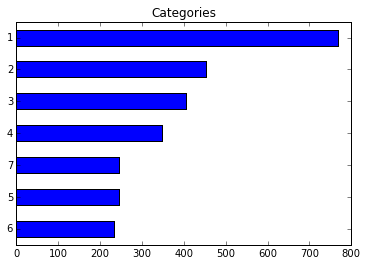

In [206]:
sorted_category_counts = df.Category.value_counts(ascending=True)
plot = sorted_category_counts.plot(kind="barh", title="Categories")

###Random raw text from each category (to develop intuition)

In [19]:
def lookup(categories, n=10):
    """Categories is a list of category numbers"""
    df_rand = pd.DataFrame()
    random_idx = np.ndarray(0)
    for category in categories:   
        rdm_idxs = np.random.choice(df[ df["Category"] == category ].index, n)
        print("---------")
        print(labels[category])
        print("---------")
        print(df.ix[rdm_idxs, ["Text"]].values)

In [20]:
lookup([i+1 for i in range(0, len(labels))], 10)

---------
Business&Finance
---------
[['why burges are green?']
 [ 'what should i do to find a good job? every time i look for a job the employers ask me for referers but this is my first time i would work.']
 [ 'what if person w/ legal custody dont give permission for me to claim dep.even though he lived w/ me for 1 yr.?']
 ['what state next to california has cheap rent?']
 ["what do you do when you're lonely?"]
 ['what is the main strip in cancun? the best street with hotels']
 ['how is the job market for ophthalmologists in washington state?']
 ['who was the first person to look at a cow and say']
 [ 'should i kiss my boyfriend and if i do it tomorrow would it be to fast he not like it?']
 ['am i cool?']]
---------
Computers&Internet
---------
[['what is seo?']
 ['how do you use myspace at school if its blocked?']
 ['what is the best free photo hosting service?']
 ['what is seo?']
 ['where can i download messenger without voice?']
 ['how can you make a website? i would like to make 

Some thing we can notice:
- Spelling mistakes. Eg "famous" -> "famoust" would influence the bag of words. Stemming might help. Or trying to group similar words under the same word. After identifying most relevant words for each category, pass again through data to identify if each word is in the query ("within" another word that is a spelling mistake or a variant)
- Some elements have questions marks but not all 
- all queries are already lowercased
- keyword:
    - business: money, price, product, debt,
    - computers: "technology, classes (ie technical term) 
- Entertainement and music has a lot of named entities: star names, fictional characters
- More what's for Education? 


##Data munging

###Splitting train and dev data

In [21]:
random_index = np.random.permutation(df.index)
df_shuffled = df.ix[random_index, ["Category", "Text"]]
df_shuffled.reset_index(drop=True, inplace=True)
df_shuffled.head(10)

rows, columns = df_shuffled.shape
print("Rows:", rows)
print("Columns:", columns)
train_size = round(rows*.7)
dev_size   = round(rows*.3)

df_train = df_shuffled.loc[:train_size]
df_dev = df_shuffled.loc[train_size:].reset_index(drop=True)

Rows: 2698
Columns: 2


###Create features

####Spellchecker

In [209]:
import enchant
d = enchant.Dict("en_US")

def generate_spellchecker():
    """ Create a dictionary of mispelled word, corrected words pairs from the text."""
    tokens = [word for query in df.Text for word in word_tokenize(query) if re.match(r"[\w]", word) is not None and
                                                                             word not in stopwords.words("english")]
    fdist = nltk.FreqDist(tokens)
    fdist_sorted = fdist.most_common()
    spellchecker = {}
    flag = 0
    for (index,(word,count)) in enumerate(fdist_sorted[::-1]):
        if not d.check(word):
            suggest_words = d.suggest(word)
            if suggest_words:
                spellchecker[word] = suggest_words[0]
    return spellchecker
spellchecker = generate_spellchecker()
spellchecker

def correct_spelling(tokens):
    return [word if token not in spellchecker else spellchecker[token] for token in tokens for word in token.split()]
    

####Tokenizer

In [210]:
pstemmer = nltk.PorterStemmer()

def tokenizer(query, spellchecker=False, tags=False, punct=True):
    """ Tokenizer for the bag of words. Steming is done with PorterStemmer. 
    Spellchecker: wether to apply a spellchecker
    Tags: whether to output as set of tags too (to be used as features)
    Punct: Wether to keep (True) or discard punctuation
    """
    tokens = word_tokenize(query)
    if spellchecker:
        tokens = correct_spelling(tokens)
    if punct:
        tokens_norm = [pstemmer.stem(token) for token in tokens]
    else:
        tokens_norm = [pstemmer.stem(token) for token in tokens if re.match(r"[\w]", token) is not None] # Removing punctuation
    if tags:
        tagged_words = nltk.pos_tag(tokens)
        _,tags = zip(*tagged_words)
        tags = list(tags)
        return tokens_norm + tags
    else:
        return tokens_norm

Spellchecking input doesn't work. 

#### Computing word similarity with wordnet

In [222]:
wnlemmatizer = nltk.WordNetLemmatizer()

def word_similarity(query):
    similarity_features = []   
    category_groups = [['Business', 'Finance'], ['Computers', 'Internet'], \
                         ['Entertainment', 'Music'], ['Family', 'Relationships'],\
                         ['Education', 'Reference'], ['Health'], ['Science', 'Mathematics']]
    
    words = word_tokenize(query)
    similarity = []
    for groups in category_groups:
        group_similarity = []
        for word in words:
            word_syns = wn.synsets(word, 'n')
            for group in groups:
                group_syns = wn.synsets(group.lower(), 'n')
                if len(word_syns) > 0 and len(group_syns) > 0:
                    similarity_value = word_syns[0].path_similarity(group_syns[0])
                    if np.isnan(similarity_value):
                        group_similarity.append(0)
                    else:
                        group_similarity.append(similarity_value)
        if np.isnan(np.mean(group_similarity)):
            similarity.append(0)
        else:
            similarity.append(np.mean(group_similarity))
            similarity_features.append(similarity)
        
    return similarity 

##Creating pipeline

###CountVectorizer

####Naive Bayes

In [278]:
combined_features = FeatureUnion([("counts", CountVectorizer())])

pipeline1 = Pipeline([
    ('features', combined_features),
    ('classifiers', MultinomialNB()),
    ])

parameters1 = {
    "features__counts__stop_words": ["english"],
    "features__counts__ngram_range": [(1,1)],
    "features__counts__min_df": [1],
    'features__counts__tokenizer': [tokenizer],
}

In [299]:
# Use combined features to transform dataset:
grid_search = GridSearchCV(pipeline1, parameters1, verbose=1, error_score=0, cv=10)
grid_search.fit(df_train.Text, df_train.Category)
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters1.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
print("Prediction score: {}".format(grid_search.predict(df.Text)))

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best score: 0.5100529100529101
Best parameters set:
	features__counts__min_df: 1
	features__counts__ngram_range: (1, 1)
	features__counts__stop_words: 'english'
	features__counts__tokenizer: <function tokenizer at 0x119d0bd40>
Prediction score: [1 6 1 ..., 6 4 6]


Tried approaches that didn't work
- tf-idf doesn't work,probably too small number of documents and not enough words per document
- wordnet similarity doesn't work

###Bag of words

####Classic count vectorizer

In [303]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=tokenizer,  min_df=1, stop_words="english")
arr_train_feature_sparse = vec.fit_transform(df_train["Text"])
arr_train_feature = arr_train_feature_sparse.toarray()
arr_train_feature.shape

(1890, 4252)

In [304]:
arr_dev_feature_sparse = vec.transform(df_dev["Text"])
arr_dev_feature = arr_dev_feature_sparse.toarray()

###Inspecting features

Can definitively improve those features

In [198]:
feature_sum = arr_train_feature.sum(axis=0)

df_feature_sum = pd.DataFrame({'counts': feature_sum})
df_feature_sum.index = vec.get_feature_names()
df_feature_sum.sort('counts', ascending=False)[:10]

,counts
?,2160
.,485
;,220
&,212
whi,184
's,173
doe,164
#,155
know,146
xa,138


Can definitively filter out stopwords

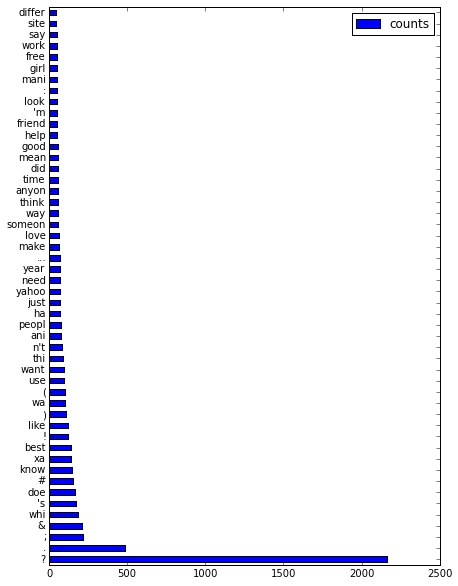

In [199]:
df_feature_sum.sort('counts', ascending=False)[:50].plot(kind='barh', figsize=(7,10));

Could do this plot for each category to have more info. 

###Train Naive Bayes and Regression Tree on data using bag of words approach

###Naive Bayes

####Train

In [200]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb_model = nb.fit(arr_train_feature, df_train.Category)

####Inspecting results

In [201]:
nb_predictions = nb_model.predict(arr_dev_feature)
nb_predictions_probs = nb_model.predict_proba(arr_dev_feature)
from sklearn.metrics import accuracy_score
accuracy_score(df_dev.Category, nb_predictions)

0.54635352286773797

In [1]:
##Cross-validation
nb_predictions_cv = cv.cross_val_predict(nb_model, arr_all_feature, df.Category, cv= 10)
# nb_predictions_probs = nb_model.predict_proba(arr_dev_feature)
accuracy_score(df.Category, nb_predictions_cv)

NameError: name 'cv' is not defined

In [142]:
class_labels = [item for item in labels.items()]
class_labels = sorted(class_labels)
_,class_labels = zip(*class_labels)
class_labels = list(class_labels)
class_labels

['Business&Finance',
 'Computers&Internet',
 'Entertainment&Music',
 'Family&Relationships',
 'Education&Reference',
 'Health',
 'Science&Mathematics']

In [143]:
from sklearn.metrics import classification_report

print(classification_report(df_dev.Category, nb_predictions, target_names=class_labels))

                      precision    recall  f1-score   support

    Business&Finance       0.45      0.73      0.56       254
  Computers&Internet       0.66      0.72      0.69       134
 Entertainment&Music       0.59      0.46      0.51       118
Family&Relationships       0.67      0.69      0.68       104
 Education&Reference       0.55      0.09      0.16        64
              Health       0.74      0.26      0.39        65
 Science&Mathematics       0.67      0.14      0.24        70

         avg / total       0.58      0.55      0.52       809



###Logistic regression

In [144]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg_model = logreg.fit(arr_train_feature, df_train.Category)

logreg_predictions = logreg_model.predict(arr_dev_feature)
logreg_predictions_probs = logreg_model.predict_proba(arr_dev_feature)
accuracy_score(df_dev.Category, logreg_predictions)

0.53646477132262049

In [145]:
print(classification_report(df_dev.Category, logreg_predictions, target_names=class_labels))

                      precision    recall  f1-score   support

    Business&Finance       0.46      0.69      0.55       254
  Computers&Internet       0.70      0.62      0.66       134
 Entertainment&Music       0.59      0.52      0.55       118
Family&Relationships       0.65      0.64      0.65       104
 Education&Reference       0.32      0.17      0.22        64
              Health       0.67      0.34      0.45        65
 Science&Mathematics       0.41      0.23      0.29        70

         avg / total       0.55      0.54      0.52       809



Can combine both those probabilities to see if we get better results. Can look at errors and set threshold on difference between the two to fit. 

### SVM

In [305]:
from sklearn.svm import SVC, LinearSVC
svm_classifier = LinearSVC()

svm_model = svm_classifier.fit(arr_train_feature, df_train.Category)
svm_predictions = svm_model.predict(arr_dev_feature)
# svm_predictions_probs = svm_model.predict_proba(arr_dev_feature)
accuracy_score(df_dev.Category, svm_predictions)

0.5426452410383189

###Combination of Naive Bayes and Logistic Regression

In [188]:
combined_predictions_probs = np.add(nb_predictions_probs, logreg_predictions_probs)
# combined_predictions_probs = np.add(svm_predictions_probs, logreg_predictions_probs)
combined_predictions = np.argmax(combined_predictions_probs, axis= 1) + 1
accuracy_score(df_dev.Category, combined_predictions)

0.54758961681087759

In [174]:
print(classification_report(df_dev.Category, combined_predictions, target_names=class_labels))

                      precision    recall  f1-score   support

    Business&Finance       0.46      0.71      0.56       254
  Computers&Internet       0.68      0.71      0.69       134
 Entertainment&Music       0.63      0.49      0.55       118
Family&Relationships       0.68      0.70      0.69       104
 Education&Reference       0.36      0.12      0.19        64
              Health       0.69      0.31      0.43        65
 Science&Mathematics       0.58      0.20      0.30        70

         avg / total       0.57      0.56      0.53       809



####Inspecting differences in probabilities between the two algorithms

In [175]:
combined_predictions_diff_idx = np.nonzero(np.subtract(nb_predictions, logreg_predictions))
len(combined_predictions_diff_idx[0])/nb_predictions.shape[0] #Percentage of differences between the two algorithms

0.24598269468479605

In [176]:
combined_predictions_probs_diff = np.subtract(np.max(nb_predictions_probs, axis=1), np.max(logreg_predictions_probs, axis=1))
counts, bins =np.histogram(combined_predictions_probs_diff, range=(-1,1), bins= 20 )

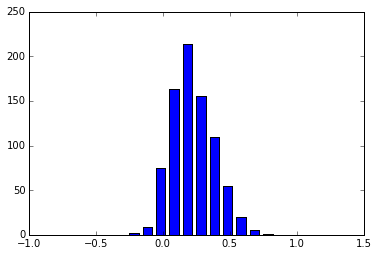

In [177]:
fig = plt.figure()
ax = fig.add_subplot(111)
## necessary variables
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
## the bars
rects1 = ax.bar(center, counts, width = width)

In [178]:
df_combined = pd.DataFrame(combined_predictions, columns=["Category"])
df_combined["Prob Diff"] = combined_predictions_probs_diff
df_combined.loc[df_combined["Prob Diff"] > .5, "Category"] = 1
accuracy_score(df_dev.Category, df_combined.Category)

0.55006180469715693

Need to look more at raw data, see where the errors are. Not look only at the end result with the scores. 

####Weighing probabilities by input frequency
Already taken into account by Naive Bayes and Logistic Regression

##Submissions

In [179]:
df_test = pd.read_csv("newtest.csv")
df_test.dtypes

Id       int64
Text    object
dtype: object

### Baseline submission

In [180]:
df_test_bl = df_test
df_test_bl["Category"] = 1
df_test_bl.to_csv("baseline_prediction.csv", columns= ["Id", "Category"], index=False)

###Create features on the whole train set and test set

In [181]:
arr_all_feature_sparse = vec.fit_transform(df["Text"])
arr_all_feature = arr_all_feature_sparse.toarray()
arr_all_feature.shape

(2698, 5288)

In [182]:
arr_test_feature_sparse = vec.transform(df_test["Text"])
arr_test_feature = arr_test_feature_sparse.toarray()

###Naive Bayes

In [185]:
#Train on all data (train + dev)
nb_model = nb.fit(arr_all_feature, df.Category)

nb_test_predictions = nb_model.predict(arr_test_feature)
nb_test_predictions_probs = nb_model.predict_proba(arr_test_feature)
df_test_nb = df_test
df_test_nb["Category"] = nb_test_predictions
df_test_nb.to_csv("nb_unigrams_filtered_predictions.csv", columns= ["Id", "Category"], index=False)

###Logistic regression

In [186]:
logreg_model = logreg.fit(arr_all_feature, df.Category)

lr_test_predictions = logreg_model.predict(arr_test_feature)
lr_test_predictions_probs = logreg_model.predict_proba(arr_test_feature)
df_test_lr = df_test
df_test_lr["Category"] = lr_test_predictions
df_test_lr.to_csv("logreg_predictions.csv", columns= ["Id", "Category"], index=False)

### SVM

In [183]:
svm_model = svm_classifier.fit(arr_all_feature, df.Category)
svm_test_predictions = svm_model.predict(arr_test_feature)
svm_test_predictions_probs = svm_model.predict_proba(arr_test_feature)

###Combined

In [351]:
combined_test_predictions_probs = np.add(nb_test_predictions_probs, lr_test_predictions_probs)
combined_test_predictions = np.argmax(combined_test_predictions_probs, axis= 1) + 1
df_test_combined = df_test
df_test_combined["Category"] = combined_test_predictions
df_test_combined.to_csv("combined_withsvm_predictions.csv", columns= ["Id", "Category"], index=False)

In [187]:
combined_test_predictions_probs = np.add(svm_test_predictions_probs, lr_test_predictions_probs)
combined_test_predictions = np.argmax(combined_test_predictions_probs, axis= 1) + 1
df_test_combined = df_test
df_test_combined["Category"] = combined_test_predictions
df_test_combined.to_csv("combined_svm_predictions.csv", columns= ["Id", "Category"], index=False)